# Tensorflow のメカニズム
- TensorFlow の計算グラフの操作と v2 への移行
- 関数デコレーションによる計算グラフのコンパイル
- TensorFlow の変数の操作
- XOR問題解決とモデルのキャパシティ
- Keras の `Model`クラスと Keras Functional API を使った複雑なニューラルネットワークモデルの構築
- 自動微分と `tf.GradientTape`を使った勾配計算
- TensorFlow Estimator の操作

## v1 での計算グラフの作成
v1 での計算グラフの構築、コンパイル、評価の手順は以下のようになる。
1. 新しい空の計算グラフをインスタンス化する
2. 計算グラフにノード（テンソルと演算）を追加する
3. 計算グラフを評価（実行）する
   1. 新しいセッションを開始する
   2. 計算グラフの変数を初期化する
   3. このセッションで計算グラフを実行する

試しに $z=2\times(a-b)+c$ を計算する計算グラフを作成する。

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# tensorflow 1.x style
# 計算グラフをインスタンス化
g = tf.Graph()
# 計算グラフにノードを追加
with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    z = 2*(a - b) + c

静的な計算グラフを定義したので Tensorflowセッションで計算グラフを実行し、tensor $z$ を評価することができる。

In [4]:
with tf.compat.v1.Session(graph=g) as sess:
    print('Result: z =', sess.run(z))

Result: z = 1


I0000 00:00:1729168839.352461   28787 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 21:40:39.391112: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-17 21:40:39.396948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


## tensorflow 1.x と 2.x のお作法の違い
tensorflow 2.x ではデフォルトで動的な計算グラフ（Eager Execution）を使う。演算の評価をその場で行うことができるため、計算グラフとセッションを明示的に作成する必要がなくなった。

In [7]:
# tensorflow 2.x style
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')
z = 2*(a - b) + c
tf.print('Result: z =', z)

Result: z = 1


また、tensorflow 2.x では pythonの変数やNumpyの配列の形式でデータを直接提供できるが、tensorflow 1.x の低レベルAPIを使っていた時は入力データをモデルに提供するためにプレースホルダを作成しなければならなかった。そうして作成したプレースホルダに `feed_dict`をつかってモデルに供給する。

In [9]:
# tensorflow 1.x style placeholder としてグラフにノードを用意し、セッションを実行する際に値を渡す
g = tf.Graph()
with g.as_default():
    a = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_a')
    b = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_b')
    c = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_c')
    z = 2*(a-b) + c

with tf.compat.v1.Session(graph=g) as sess:
    feed_dict = {a:1, b:2, c:3}
    print('Result: z =', sess.run(z, feed_dict=feed_dict))

Result: z = 1


tensorflow 2.x では 「python の通常の関数を定義する」だけでよい

In [10]:
# tensorflow 2.x style 引数をもつ関数を用意する
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

In [11]:
tf.print(compute_z(1,2,3))

1


In [13]:
compute_z(1,2,3)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

## 2.x で関数デコレータを使う
python の関数をデコレートして計算グラフにすることで、計算を高速化することが可能である。関数デコレータを使うと、 Tensorflow が入力引数に基づいて静的な計算グラフを作成するようになっている。そうすることで実行を高速化することができる。

In [3]:
@tf.function
def conput_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

呼び出し方は 2.x と同じになる。

In [4]:
tf.print(conput_z(1, 2, 3))

1


I0000 00:00:1729204284.147591    1110 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-18 07:31:24.344458: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Tensorflow の Variable オブジェクト
`Variable` は訓練中にモデルのパラメータを格納・更新することができるオブジェクト。このオブジェクトは常に初期値を与えなければならない。

In [5]:
a = tf.Variable(initial_value=3.14, name='var_a')
print(a)

b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
print(b)

c = tf.Variable(initial_value=[True, False], dtype=tf.bool)
print(c)

d = tf.Variable(initial_value=['abc'], dtype=tf.string)
print(d)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


In [8]:
# 値の変更
w = tf.Variable([1, 2, 3], trainable=False)
print(w.trainable) # Keras などの高APIはこれを使って訓練可能なパラメータを区別する

print(w.assign([3, 1, 4], read_value=True))
w.assign_add([2, -1, 2], read_value=False)
print(w.value())

False
<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4], dtype=int32)>
tf.Tensor([5 0 6], shape=(3,), dtype=int32)


### Xavier/Glorot 初期化
keras の initializers を用いて初期化してみる

In [9]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()
tf.print(init(shape=(3,)))

[-0.409769207 0.84014 0.146128714]


In [10]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[-0.448879659 0.920327246 0.160075977]
 [-0.594845414 -0.990628242 0.0834724456]]


### `tf.Module` クラスで `Variable` を定義する
訓練可能な変数と訓練可能ではない変数を1つずつ定義する

In [11]:
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)
    
m = MyModule()
print('All module variables:', [v.shape for v in m.variables])

print('Trainable variable:', [v.shape for v in m.trainable_variables])

All module variables: [TensorShape([2, 3]), TensorShape([1, 2])]
Trainable variable: [TensorShape([2, 3])]


デコレートされていない通常の関数内で `Variable` を定義するときには、この関数を呼び出すたびに新しい `Variable` が作成され初期化される。しかし、 `tf.function` はトレーシングと計算グラフの作成に基づいて Variable の再利用を試みる。このため、 Tensorflow はデコレートされた関数内での `Variable` の作成を許可しない。

In [12]:
@tf.function
def f(x):
    w = tf.Variable([1, 2, 3])

f([1])

ValueError: in user code:

    File "/tmp/ipykernel_1110/3936897465.py", line 3, in f  *
        w = tf.Variable([1, 2, 3])

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


デコレートされた関数の外で定義した `Variable` を関数の中で使う。

In [14]:
tf.random.set_seed(1)
w = tf.Variable(tf.random.uniform((3,3)))

@tf.function
def compute_z(x):
    return tf.matmul(w, x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)
tf.print(w)
tf.print(compute_z(x))

[[0.165130854 0.901481271 0.630974174]
 [0.434546113 0.29193902 0.642502069]
 [0.975785494 0.435099483 0.660101891]]
[[3.8610158]
 [2.94593048]
 [3.82629013]]


## 自動微分と `GradientTape` による勾配の計算
学習には Loss の勾配を計算しなければならないが、Loss の勾配を計算する際に最適化のアルゴリズムが必要になる。Tensorfloww は自動微分をサポートしている。自動微分は入れ子の関数の勾配を計算するための連鎖律の実装として考えることができる。

$z = wx + b$ を計算し、目的変数と予測値の間の二乗損失 $Loss = (y-z)^2$ を計算してみる。この計算を Tensorflow で実装するにはモデルパラメータ $w$ と $b$ は変数(`tf.Variable`)として定義し、入力 $x$ と $y$ はテンソルとして定義する。$z$ の計算と損失項は `tf.GradientTape` のコンテキスト内に配置する。

In [2]:
w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

# 計算グラフと損失計算はコンテキスト内におく
with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw:', dloss_dw)

True True
dL/dw: -0.559999764


I0000 00:00:1729307735.203205    1106 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19 12:15:35.401614: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


`tf.GradientTape` は訓練可能な変数については勾配の計算を自動でサポートする。しかし、訓練可能ではない変数やほかのTensorオブジェクトについては `tf.GradientTape` の `watch` メソッドを使って監視する必要がある。

In [4]:
with tf.GradientTape() as tape:
    tape.watch(x) # x はただのtensor objectなため watch する
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dx = tape.gradient(loss, x)
tf.print('dL/dx:', dloss_dx)

dL/dx: [-0.399999857]


勾配は計算されているが、パラメータが更新されているわけではない。

In [6]:
print(w, b)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>


複数の勾配を計算するためには勾配テープを永続化させる必要がある。手動で複数の勾配を使ってパラメータ更新しなければならないときなどで使える。

In [20]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw:', dloss_dw)

dloss_db = tape.gradient(loss, b)
tf.print('dL/db:', dloss_db)

dL/dw: -0.26091519
dL/db: -0.186367989


In [21]:
# パラメータ更新
optimizer = tf.keras.optimizers.SGD()
optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))
tf.print('Updated w:', w)
tf.print('Updated b:', b)

Updated w: 1.05313
Updated b: 0.537950277


## Keras の `Sequential` クラスを使った一般的なアーキテクチャ実装
2つの全結合層からなるモデルを構築する。

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
# 遅延変数作成
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624 (2.44 KB)

 Trainable params: 624 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# モデル変数の出力
for v in model.variables:
    print(f'{v.name:20s}', v.trainable, v.shape)

kernel               True (4, 16)
bias                 True (16,)
kernel               True (16, 32)
bias                 True (32,)


`kernel` という重み行列とバイアスベクトルがある。

層の設定をする。活性化関数、変数イニシャライザ、正則化手法をパラメータに適用することができる。

In [25]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=16,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.glorot_uniform(),
    bias_initializer=tf.keras.initializers.Constant(2.0)
))
model.add(tf.keras.layers.Dense(
    units=32,
    activation=tf.keras.activations.sigmoid,
    kernel_regularizer=tf.keras.regularizers.l1
))

モデルをコンパイルする際にオプティマイザ・損失関数・性能指標を設定することができる。

In [27]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),])

## XOR問題を解く


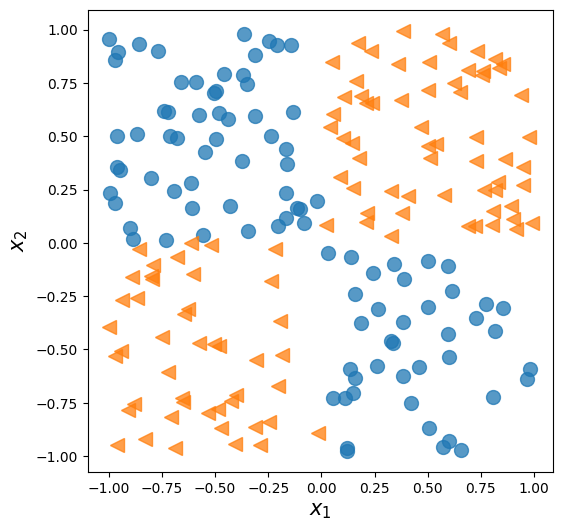

In [29]:
tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [30]:
# ベースラインモデルの作成
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(2,), activation='sigmoid'))
model.summary()

/home/hoyo/work/training/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

  236/20000 ━━━━━━━━━━━━━━━━━━━━ 8s 427us/step

/tmp/ipykernel_1106/385804224.py:19: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 8s 398us/step


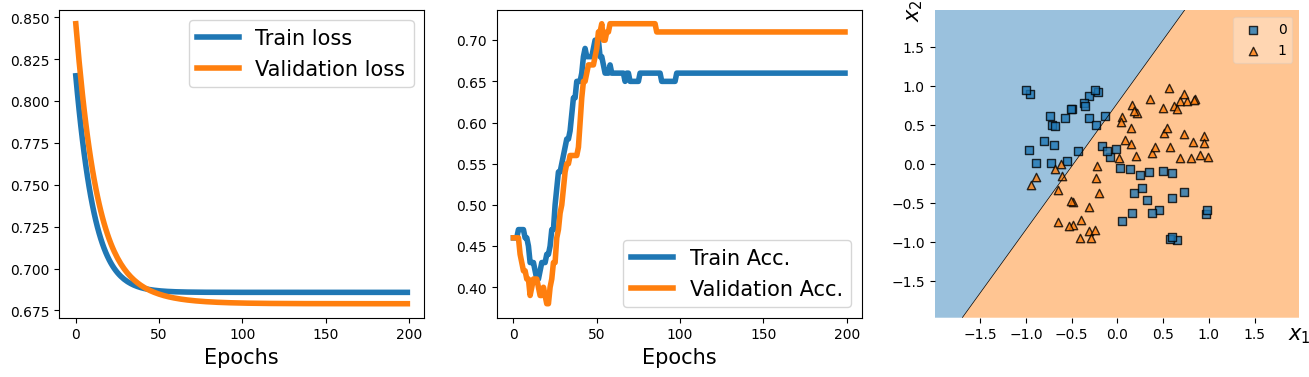

In [32]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

隠れ層をもたない単純なモデルは線形の決定境界しか抽出することができない（XOR問題は解けない）。

非線形の決定境界を抽出するために、非線形の活性化関数で結合された隠れ層を1つ以上追加すればよい。普遍性定理（universal approximate theorem）によれば、比較的隠れユニットが多い隠れ層1つあるネットワークは任意の連続関数を近似できる。

とはいえ、層が深いモデルは勾配消失問題や勾配発散問題に陥りやすい。

In [33]:
tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

/home/hoyo/work/training/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

  236/20000 ━━━━━━━━━━━━━━━━━━━━ 8s 430us/step

/tmp/ipykernel_1106/3923813790.py:17: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 8s 422us/step


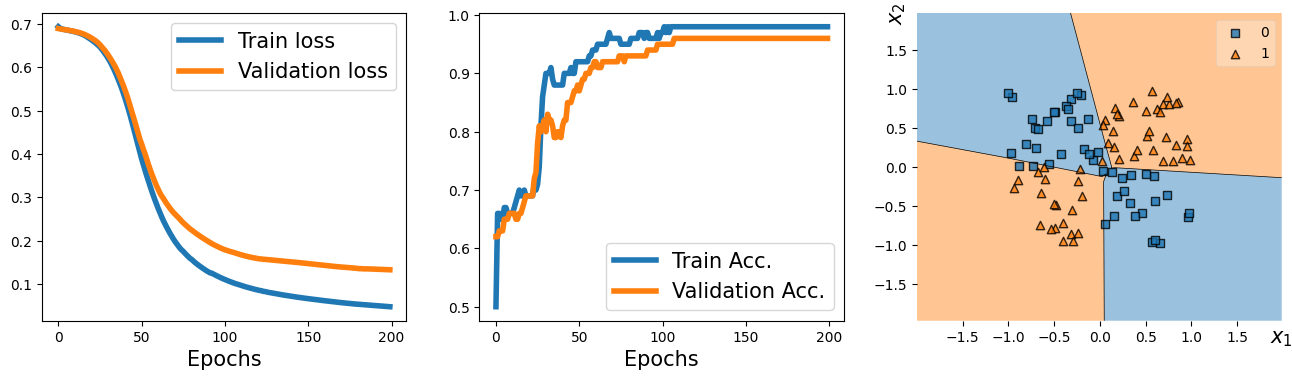

In [35]:
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## Functional API によるモデル構築

In [36]:
tf.random.set_seed(1)
# 入力層
inputs = tf.keras.Input(shape=(2,))
# 隠れ層
h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)
# 出力層
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)
# モデル構築
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
# モデルコンパイル
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# training
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

    1/20000 ━━━━━━━━━━━━━━━━━━━━ 11:25 34ms/step

/tmp/ipykernel_1106/3693794237.py:18: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 9s 426us/step


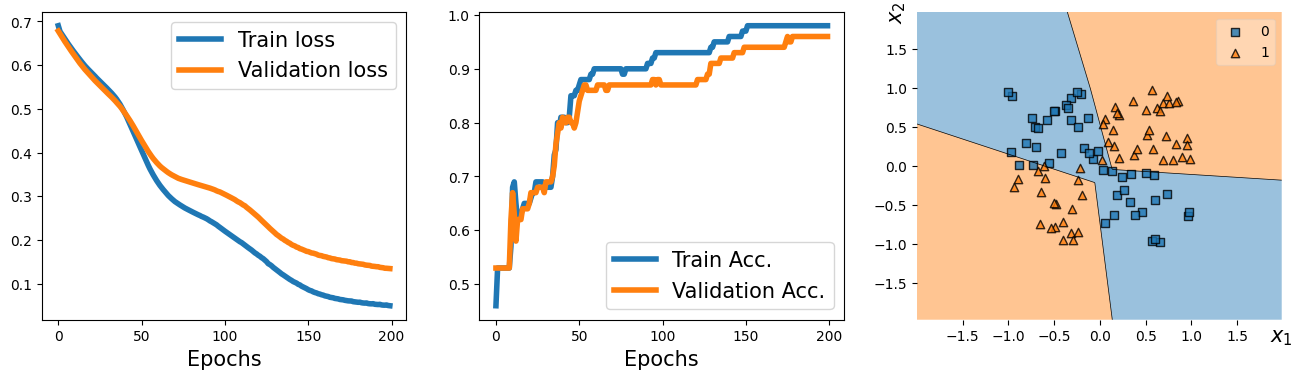

In [38]:
## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## `tf.keras.Model` のサブクラス化によるモデル構築
- コンストラクタ`__init__`にクラスの属性として層を定義する。
- `call` メソッドでニューラルネットワークのフォワードパスでこれらの層をどのように使うのかを定義する。

サブクラスであるモデルは `build`, `complie`, `fit` などのメソッドを継承している。

In [42]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
        
    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

In [43]:
tf.random.set_seed(1)
model = MyModel()
model.build(input_shape=(None, 2))
model.summary()
# コンパイル
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
# training
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

/home/hoyo/work/training/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'my_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "my_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

  230/20000 ━━━━━━━━━━━━━━━━━━━━ 8s 441us/step

/tmp/ipykernel_1106/3693794237.py:18: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 9s 437us/step


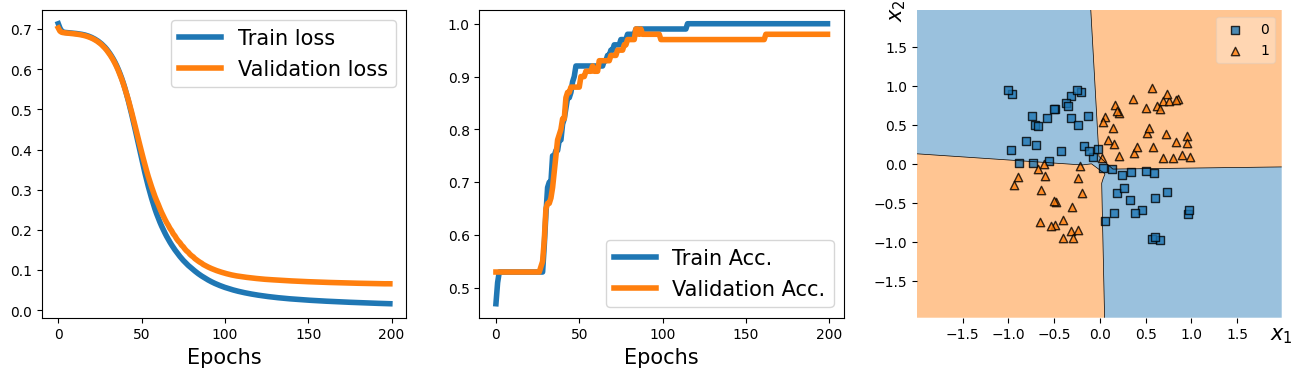

In [41]:
## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## カスタム層の定義
$w(x+\epsilon)+b$を定義するために、`tf.keras.layers.Layer` のサブクラスとして新しいクラスを定義する。

In [44]:
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='random_normal',
                                 trainable=True)
        
        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)

            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)
    
    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev})
        return config


In [45]:
tf.random.set_seed(1)

noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(None, 4))

x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))

## re-building from config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0 0 0.00189234538 0.00182246428]]
[[0 0.00378837925 0 0]]


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noisy_linear_1 (NoisyLinear)    │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

  242/20000 ━━━━━━━━━━━━━━━━━━━━ 8s 420us/step

/tmp/ipykernel_1106/2154352697.py:40: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 8s 412us/step


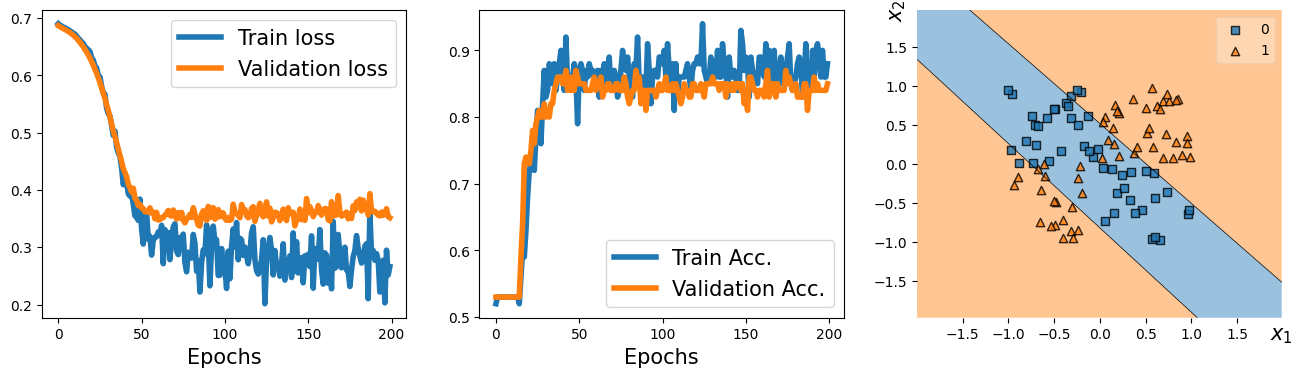

In [46]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

model.build(input_shape=(None, 2))
model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, 
                 verbose=0)

## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()